In [27]:
import itertools
import os
from collections import namedtuple
from math import exp, log

import luigi
import dill
import numpy as np
from scipy.stats import binom

from experiment_framework.helpers import AllAsymptotics, \
load_completed_AAs_into_dataframe, load_completed_CCCs_into_dataframe
from empirical_privacy import laplace_mechanism, config
from experiment_framework.asymptotic_analysis import compute_bootstrapped_upper_bound
from experiment_framework.calculations import statistical_distance_to_accuracy, accuracy_to_statistical_distance
from notebook_context import *

In [2]:
epsilons = [
    0.01,
    0.1,
    1.,
]
dses = [{
        'database_0' : (0, 0, 0),
        'database_1' : (1, 0, 0),
        'sensitivity': 1.,
        'epsilon'    : eps,
        'delta'      : 0.
} for eps in epsilons]

asys = {
    'gen_sample_kwargs'  : {'generate_in_batch': True,
                            'x_concatenator': 'numpy.vstack'
                           },
    'fitter'             : 'knn',
    # we use random tie-breaking since the samples are discrete
    'fitter_kwargs'      : {'neighbor_method': 'gyorfi'},
    'n_docs'                : 30,
    'confidence_interval_width': 20,
    'n_max'              : 2**14,
    'validation_set_size': 2**12,
    'p'                  : 0.9,  # for bootstrap
    't'                  : 0.001  # for bootstrap
}

def sd(eps, delta):
    return exp(eps)-1+delta

def pc(eps, delta):
    sd_ = sd(eps, delta)
    return statistical_distance_to_accuracy(sd_)

for (i, ds) in enumerate(dses):
    eps = ds["epsilon"]
    delta = ds["delta"]
    print(f'{i} Expected SD={sd(eps, delta):.3f} P(correct)={pc(eps, delta):.3f}')

0 Expected SD=0.010 P(correct)=0.505
1 Expected SD=0.105 P(correct)=0.553
2 Expected SD=1.718 P(correct)=1.359


In [18]:
CCCs = dict()
Alls = dict()
for (i, ds) in enumerate(dses):
    eps = epsilons[i]
    All = AllAsymptotics(
            gen_sample_path='empirical_privacy.laplace_mechanism.GenSampleLaplaceMechanism',
            dataset_settings=ds,
            asymptotic_settings=asys)
    Alls[eps] = All
#     for AA in All.requires():
#         AA.delete_outputs()
#         AA.delete_deps()
    CCCs[eps] = [AA.requires()['CCC'] for AA in All.requires()]
    

/opt/conda/lib/python3.6/site-packages/luigi/parameter.py:261: UserWarning: Parameter "random_seed" with value "0" is not of type string.
  warnings.warn('Parameter "{}" with value "{}" is not of type string.'.format(param_name, param_value))
/opt/conda/lib/python3.6/site-packages/luigi/parameter.py:261: UserWarning: Parameter "random_seed" with value "0" is not of type string.
  warnings.warn('Parameter "{}" with value "{}" is not of type string.'.format(param_name, param_value))
/opt/conda/lib/python3.6/site-packages/luigi/parameter.py:261: UserWarning: Parameter "random_seed" with value "0" is not of type string.
  warnings.warn('Parameter "{}" with value "{}" is not of type string.'.format(param_name, param_value))
/opt/conda/lib/python3.6/site-packages/luigi/parameter.py:261: UserWarning: Parameter "random_seed" with value "0" is not of type string.
  warnings.warn('Parameter "{}" with value "{}" is not of type string.'.format(param_name, param_value))
/opt/conda/lib/python3.6/sit

In [20]:
CCC_jobs = list(itertools.chain(*[[AA.requires()['CCC'] for AA in All.requires()] for All in Alls.values()]))
luigi.build(CCC_jobs, workers=16, log_level='ERROR', local_scheduler=True)  # compute CCCs using 16 workers since they're single threaded
luigi.build([All for All in Alls.values()], workers=2, log_level='ERROR', local_scheduler=True)  # do bootstrap using 2 workers since each bootstrap is parallelized

True

### Plot outcomes for all trials

In [21]:
import pandas as pd

from scipy.optimize import least_squares


from experiment_framework.asymptotic_analysis import hoeffding_n_given_t_and_p_one_sided, bootstrap_ci,\
    asymptotic_privacy_lr, transform_n_to_k_for_knn, asymptotic_curve
from experiment_framework.privacy_estimator_mixins import get_k

### Plot for a particular epsilon

In [30]:
eps = 0.1
ds = dses[epsilons.index(eps)]
delta = ds['delta']

All = AllAsymptotics(
            gen_sample_path='empirical_privacy.laplace_mechanism.GenSampleLaplaceMechanism',
            dataset_settings=ds,
            asymptotic_settings=asys)
CCCs = [AA.requires()['CCC'] for AA in All.requires()]

AAs = All.requires()
DF = load_completed_AAs_into_dataframe(AAs)


w/ prob 90.0% min eps is 0.04387226340012952


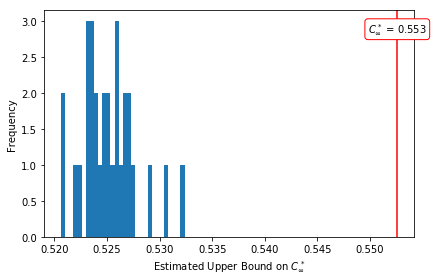

In [33]:
ax = DF.upper_bound.plot(kind='hist', bins=30)
true_ub = pc(eps, delta)
plt.axvline(x=true_ub, color='r')
plt.text(x=true_ub,
         y=0.9,
         s='$C_\infty^*$ = {:.3f}'.format(true_ub),
         transform=x_data_y_axis(),
         horizontalalignment='center',
         bbox=dict(facecolor='w', edgecolor='r', boxstyle='round')
        )
plt.xlabel('Upper Bound on $P[$Correct$]$')


min_eps = accuracy_to_statistical_distance(DF.upper_bound.quantile(1-asys['p']))
min_eps = log(min_eps+1)
print(f"w/ prob {asys['p']*100}% min eps is {min_eps}")

if SAVE_FIGURES_FOR_LATEX:
    plt.title('')
    plt.ylabel('Frequency')
    plt.xlabel('Estimated Upper Bound on $C^*_\infty$')
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_PATH, 'experiment_4_upper_bound_histogram.eps'))

In [48]:
configure_plotting_for_publication()

SAVE_FIGURES_FOR_LATEX = False


import pandas as pd

from scipy.optimize import least_squares


from experiment_framework.asymptotic_analysis import hoeffding_n_given_t_and_p_one_sided, bootstrap_ci,\
    asymptotic_privacy_lr, transform_n_to_k_for_knn, asymptotic_curve
from experiment_framework.privacy_estimator_mixins import get_k

(4200, 12)
Training set sizes =  1024 -- 16384
m=0.5169272184755977 C=0.12479978891530917


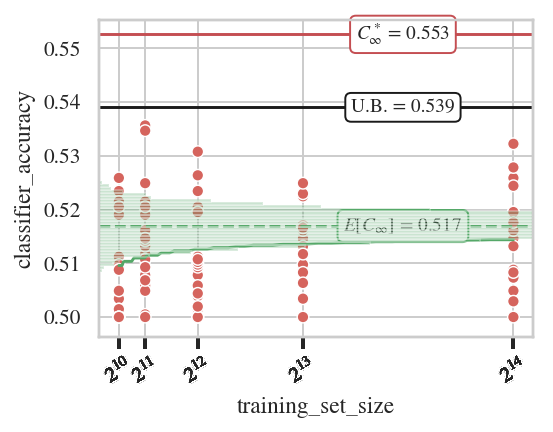

In [49]:
DFccc = load_completed_CCCs_into_dataframe(CCCs)
print(DFccc.shape)

confidence_interval_width = 0.01
confidence_interval_prob = 0.9
    
def plot_CCC_DF(DF, doc_ind=None, d=3, min_tss=None):
    global SAVE_FIGURES_FOR_LATEX
    if doc_ind is not None:
        DF = DF.loc[DF.doc_ind == doc_ind, :]
    if min_tss is not None:
        DF = DF[DF.training_set_size >= min_tss]
    print('Training set sizes = ',
      DF.training_set_size.min(),
      '--',
      DF.training_set_size.max()
     )
    DF.loc[DF.classifier_accuracy < 0.5, 'classifier_accuracy'] = 0.5
    n_docs = DF.doc_ind.nunique()
    cp = sns.color_palette('hls', n_docs, desat=0.9)
    handle = sns.scatterplot(
        data=DF,
        x='training_set_size',
        y='classifier_accuracy',
        hue='doc_ind',
        legend=None,
        palette=cp,
    
    )
   
    # curve for all the data
    d=3
    fit_model = 'gyorfi'
    x = DF.training_set_size.values.astype(np.double)
    ks = transform_n_to_k_for_knn(x, fit_model, d=d)
    y = DF.classifier_accuracy.values
    m, C = asymptotic_curve(ks, y)
    print(f'm={m} C={C}')
    
    # bootstrap for ub
    boot_res = compute_bootstrapped_upper_bound(x, d, fit_model, y,
                                 confidence_interval_prob,
                                 confidence_interval_width)
    samples = boot_res['bootstrap_samples'] 
    
    ub = boot_res['ub']
    base = config.SAMPLES_BASE
    xx = np.logspace(np.log(np.min(x))/np.log(base),
                     np.log(np.max(x))/np.log(base),
                    base=base)
    kks = transform_n_to_k_for_knn(xx, fit_model, d=d)
    plt.plot(xx, m+C*kks, '-g')
    
    labeled_axhline(ub, 'U.B.', 'k', handle)
    labeled_axhline(m, '$E[C_\infty]$', 'g', handle, linestyle='--')
    labeled_axhline(pc(eps, delta), '$C_\infty^*$', 'r', handle)
    
    plt.xticks(x, ['$2^{%s}$'%'{:}'.format(int(np.log(xx)/np.log(2))) for xx in x],
              rotation=30)
    
    if SAVE_FIGURES_FOR_LATEX:
        plt.xlabel('Training Set Size')
        plt.ylabel('P[correct]')
    
    ax2 = handle.twiny()
    ax2.set_xlim(0, 100.0)
    ax2.set_xticks([])
    sns.distplot(a=samples,
                 bins=30,
                 hist=True,
                 hist_kws={'alpha':0.30},
                 norm_hist=True,
                 kde=False,
                 kde_kws={'linestyle':':', 'alpha':0.75},
                 rug=False,
                 vertical=True,
                 color='g',
                ax=ax2)

    if SAVE_FIGURES_FOR_LATEX:
        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_PATH, 'experiment_4_bootstrap_visualization.png'))


    
# call the function
plot_CCC_DF(DFccc, 1, min_tss=2**10)
